In [2]:
!pip install keras-tuner

In [3]:
from keras.models import Sequential #Сеть прямого распространения
#Базовые слои для счёрточных сетей
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Rescaling
from keras.preprocessing.image import ImageDataGenerator # работа с изображениями
from keras.optimizers import Adam, Adadelta # оптимизаторы
from keras import utils #Используем дял to_categoricall
from keras.preprocessing import image #Для отрисовки изображений
from google.colab import files #Для загрузки своей картинки
import numpy as np #Библиотека работы с массивами
import matplotlib.pyplot as plt #Для отрисовки графиков
from PIL import Image #Для отрисовки изображений
import random #Для генерации случайных чисел
import math # Для округления
import os #Для работы с файлами
import keras
import keras_tuner as kt
# подключем диск
from google.colab import drive

%matplotlib inline
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Распознавание изображений из набора данных Cifar10



In [14]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])

x = x / 255
y = utils.to_categorical(y, 10)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

In [15]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='silu'),
    Conv2D(32, (3, 3), padding='same', activation='silu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='silu'),
    Conv2D(64, (3, 3), padding='same', activation='silu'),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.2),
    Conv2D(128, (3, 3), padding='same', activation='silu'),
    Conv2D(128, (3, 3), padding='same', activation='silu'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Dropout(0.2),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax'),
])

In [16]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, verbose=True, epochs=10, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/10
375/375 [==============================] - 265s 701ms/step - loss: 1.3896 - accuracy: 0.4930 - val_loss: 3.6069 - val_accuracy: 0.1423
Epoch 2/10
375/375 [==============================] - 245s 653ms/step - loss: 0.8980 - accuracy: 0.6838 - val_loss: 0.8709 - val_accuracy: 0.6947
Epoch 3/10
375/375 [==============================] - 252s 671ms/step - loss: 0.7053 - accuracy: 0.7518 - val_loss: 0.9261 - val_accuracy: 0.6910
Epoch 4/10
375/375 [==============================] - 247s 660ms/step - loss: 0.5862 - accuracy: 0.7946 - val_loss: 0.6395 - val_accuracy: 0.7810
Epoch 5/10
375/375 [==============================] - 252s 673ms/step - loss: 0.5092 - accuracy: 0.8213 - val_loss: 0.6659 - val_accuracy: 0.7723
Epoch 6/10
375/375 [==============================] - 252s 672ms/step - loss: 0.4409 - accuracy: 0.8449 - val_loss: 0.6973 - val_accuracy: 0.7722
Epoch 7/10
375/375 [==============================] - 250s 668ms/step - loss: 0.3849 - accuracy: 0.8641 - val_loss: 0.6469 -

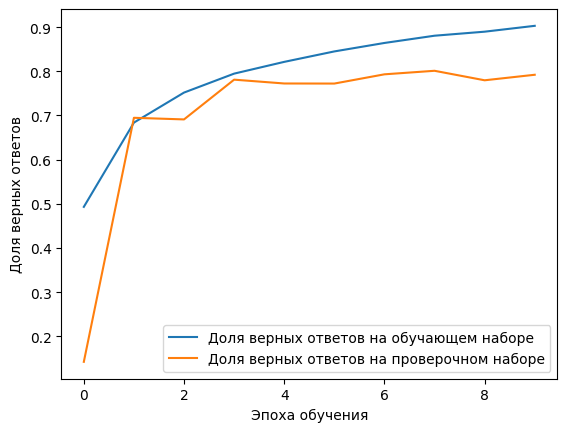

In [17]:
plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Распознавание марок машин

In [27]:
!unzip 'Автомобили/Автомобили.zip'

Archive:  Автомобили/Автомобили.zip
replace Автомобили/train/Ferrari/car_Ferrari__0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [28]:
path_train = "Автомобили/train"
path_val = "Автомобили/val"
batch_size = 32
img_width = 192
img_height = 108

In [29]:
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

image_size = (img_width, img_height)

train_generator = datagen.flow_from_directory(
    path_train,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    path_val,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2743 images belonging to 3 classes.
Found 684 images belonging to 3 classes.


In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
  model.add(keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(keras.layers.MaxPooling2D(pool_size=(3, 3)))
  model.add(keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(Dropout(hp.Choice('dropout_rate', [0.2, 0.3, 0.4])))
  model.add(keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(keras.layers.MaxPooling2D(pool_size=(3, 3)))
  model.add(Dropout(hp.Choice('dropout_rate', [0.2, 0.3, 0.4])))
  model.add(keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu'))
  model.add(keras.layers.MaxPooling2D(pool_size=(3, 3)))
  model.add(Dropout(hp.Choice('dropout_rate', [0.2, 0.3, 0.4])))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(2048, activation='relu'))
  model.add(keras.layers.Dense(4096, activation='relu'))
  model.add(keras.layers.Dense(len(train_generator.class_indices), activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
  return model

In [ ]:
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=6,
                     directory='my_dir',
                     project_name='intro')

Reloading Tuner from my_dir/intro/tuner0.json


In [ ]:
tuner.search(train_generator, epochs=5, validation_data=(val_generator))
best_model = tuner.get_best_models()[0]

Trial 8 Complete [00h 01m 41s]
val_accuracy: 0.34310850501060486

Best val_accuracy So Far: 0.5337243676185608
Total elapsed time: 00h 19m 17s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size,
    epochs=45,
    verbose=1
)

Epoch 1/45


<ipython-input-53-0ce07fe8454d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


123/123 [==============================] - 18s 130ms/step - loss: 1.1478 - accuracy: 0.3293 - val_loss: 1.0977 - val_accuracy: 0.3354
Epoch 2/45
123/123 [==============================] - 16s 129ms/step - loss: 1.0990 - accuracy: 0.3319 - val_loss: 1.0978 - val_accuracy: 0.3477
Epoch 3/45
123/123 [==============================] - 15s 125ms/step - loss: 1.1021 - accuracy: 0.3728 - val_loss: 1.0971 - val_accuracy: 0.3692
Epoch 4/45
123/123 [==============================] - 16s 128ms/step - loss: 1.0986 - accuracy: 0.3378 - val_loss: 1.0983 - val_accuracy: 0.3385
Epoch 5/45
123/123 [==============================] - 16s 130ms/step - loss: 1.0991 - accuracy: 0.3434 - val_loss: 1.0978 - val_accuracy: 0.3415
Epoch 6/45
123/123 [==============================] - 16s 131ms/step - loss: 1.0982 - accuracy: 0.3329 - val_loss: 1.0981 - val_accuracy: 0.3385
Epoch 7/45
123/123 [==============================] - 16s 127ms/step - loss: 1.0981 - accuracy: 0.3427 - val_loss: 1.0978 - val_accuracy: 0.3

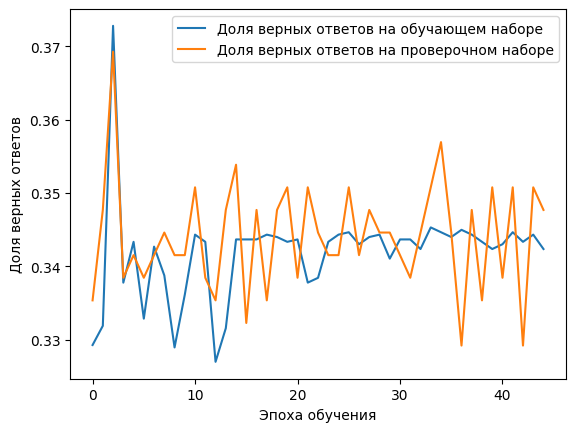

In [ ]:
#Оображаем график точности обучения
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()